In [1]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import affine_transform
from scipy.ndimage import rotate

In [2]:
# Ужимаем в 2 раза
resize_coef = 2
dicom_directory = r"D:\DICOM\BELKINA YU.N. 37" # ДИРЕКТОРИЯ с файлами DICOM на локальном диске

def load_dicom_images_sitk(directory, resize_factor=1/resize_coef):
    # Чтение DICOM
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(directory)
    reader.SetFileNames(dicom_names)
    image = reader.Execute()

    # Уменьшение
    original_size = image.GetSize()
    original_spacing = image.GetSpacing()
    new_size = [int(sz * resize_factor) for sz in original_size]
    new_spacing = [osz/nsz * osp for osz, nsz, osp in zip(original_size, new_size, original_spacing)]

    return sitk.Resample(image, new_size, sitk.Transform(), sitk.sitkLinear, image.GetOrigin(), 
                         new_spacing, image.GetDirection(), 0, image.GetPixelID())

# Загрузка DICOM
images_sitk = load_dicom_images_sitk(dicom_directory)
# Конвертация изображений в трехмерный массив numpy
np_images = sitk.GetArrayFromImage(images_sitk)

print('ok')

ok


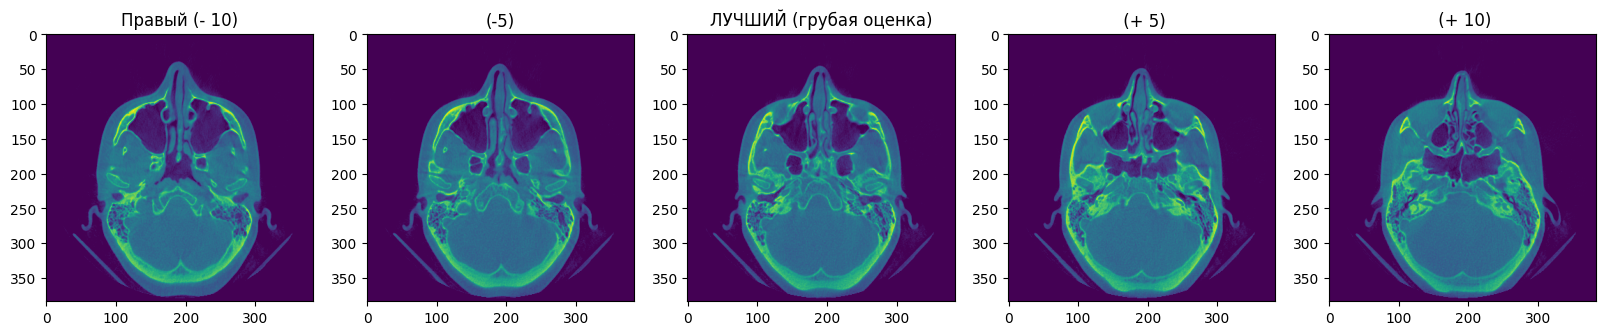

In [6]:
# ПРАВЫЙ МЫЩЕЛОК
# ГРУБАЯ оценка. Смотрим срезы в глубине. Корректируем shift0_r пока не найдём ЛУЧШИЙ МЫЩЕЛОК.
# НАДО КОРРЕКТИРОВАТЬ:
shift0_r = 179 - 5
#
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 8))
axes[0].set_title("Правый (- 10)")
axes[0].imshow(np_images[shift0_r-10,:,:])
axes[1].set_title("(-5)")
axes[1].imshow(np_images[shift0_r-5,:,:])
axes[2].set_title("ЛУЧШИЙ (грубая оценка)")
axes[2].imshow(np_images[shift0_r,:,:])
axes[3].set_title(" (+ 5)")
axes[3].imshow(np_images[shift0_r+5,:,:])
axes[4].set_title(" (+ 10)")
axes[4].imshow(np_images[shift0_r+10,:,:])


In [7]:
# ПРАВЫЙ. Вырезаем кубик вокруг правого мыщелка. Сторона кубика = половине стороны среза.
r_box_side = round(np_images.shape[2]/2)
r_box_top = round((np_images.shape[0] - r_box_side)/2)
r_box_bottom = r_box_top + r_box_side
r_box_left =  r_box_side
r_box_right = np_images.shape[2]
r_box_forward = round(np_images.shape[2]/4)
r_box_back = r_box_forward + r_box_side
r_box = np_images[r_box_top:r_box_bottom , r_box_forward:r_box_back , r_box_left:r_box_right]

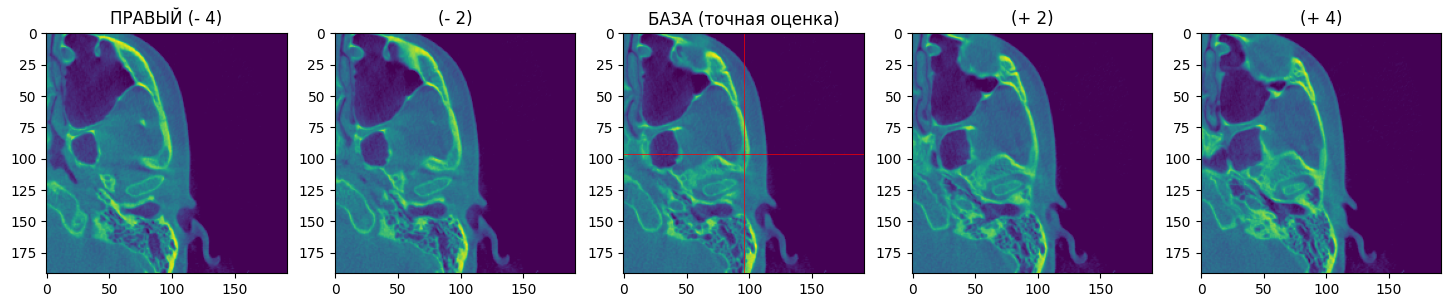

In [9]:
# ПРАВЫЙ. ТОЧНАЯ оценка глубины. Корректируем r_shift0 пока не найдём САМЫЙ ЛУЧШИЙ МЫЩЕЛОК. Это будет БАЗА
# НАДО КОРРЕКТИРОВАТЬ:
r_shift0 = shift0_r - 48 -1 
# 
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(18, 6))
axes[0].set_title("ПРАВЫЙ (- 4)")
axes[0].imshow(r_box[r_shift0-4,:,:])
axes[1].set_title("(- 2)")
axes[1].imshow(r_box[r_shift0-2,:,:])
axes[2].set_title("БАЗА (точная оценка)")
axes[2].imshow(r_box[r_shift0,:,:])
axes[2].axhline(r_box.shape[0] / 2, color='red', linewidth=0.5)
axes[2].axvline(r_box.shape[0] / 2, color='red', linewidth=0.5)
axes[3].set_title("(+ 2)")
axes[3].imshow(r_box[r_shift0+2,:,:])
axes[4].set_title("(+ 4)")
axes[4].imshow(r_box[r_shift0+4,:,:])
plt.show()

In [10]:
# ПРАВЫЙ. Сдвиг в ГЛУБИНУ на уровень БАЗА
translation_matrix0_r = np.array([[1, 0, 0, r_shift0],
                               [0, 1, 0, 0],
                               [0, 0, 1, 0],
                               [0, 0, 0, 1]])
r_shifted_volume0 = affine_transform(r_box, translation_matrix0_r, order=0, mode='constant')

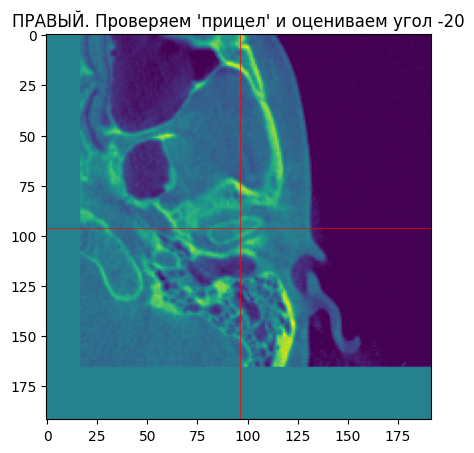

In [17]:
# ПРАВЫЙ. Корректируем r_shift1 и r_shift2 пока не установим 'ПРИЦЕЛ' в центр мыщелка)
# НАДО КОРРЕКТИРОВАТЬ: 
r_shift1 = 34 -8 # сдвиг вверх
r_shift2 = -17 # сдвиг вправо
r_angle = -20 # угол поворота
#
translation_matrix1_r = np.array([[1, 0, 0, 0],
                               [0, 1, 0, r_shift1],
                               [0, 0, 1, 0],
                               [0, 0, 0, 1]])
translation_matrix2_r = np.array([[1, 0, 0, 0],
                               [0, 1, 0, 0],
                               [0, 0, 1, r_shift2],
                               [0, 0, 0, 1]])
r_shifted_volume01 = affine_transform(r_shifted_volume0, translation_matrix1_r, order=0, mode='constant')
r_shifted_volume02 = affine_transform(r_shifted_volume01, translation_matrix2_r, order=0, mode='constant')
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
axes.set_title("ПРАВЫЙ. Проверяем 'прицел' и оцениваем угол "+ str(r_angle))
axes.imshow(r_shifted_volume02[0])
axes.axhline(r_shifted_volume02[0].shape[0] / 2, color='red', linewidth=0.5)
axes.axvline(r_shifted_volume02[0].shape[1] / 2, color='red', linewidth=0.5)
plt.show()

In [18]:
# Трансформируем КУБИК и поворачиваем вокруг оси 0 (торчком)
r_shifted_volume1 = affine_transform(r_box, translation_matrix1_r, order=0, mode='constant')
r_shifted_volume2 = affine_transform(r_shifted_volume1, translation_matrix2_r, order=0, mode='constant')
r_rotated_volume2 = rotate(r_shifted_volume2, r_angle, axes=(1, 2), reshape=False, mode='nearest')
center = r_rotated_volume2[0::].shape[0] / 2

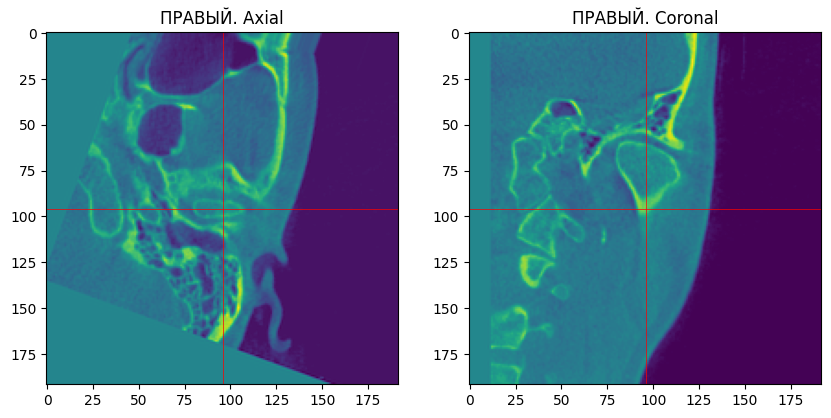

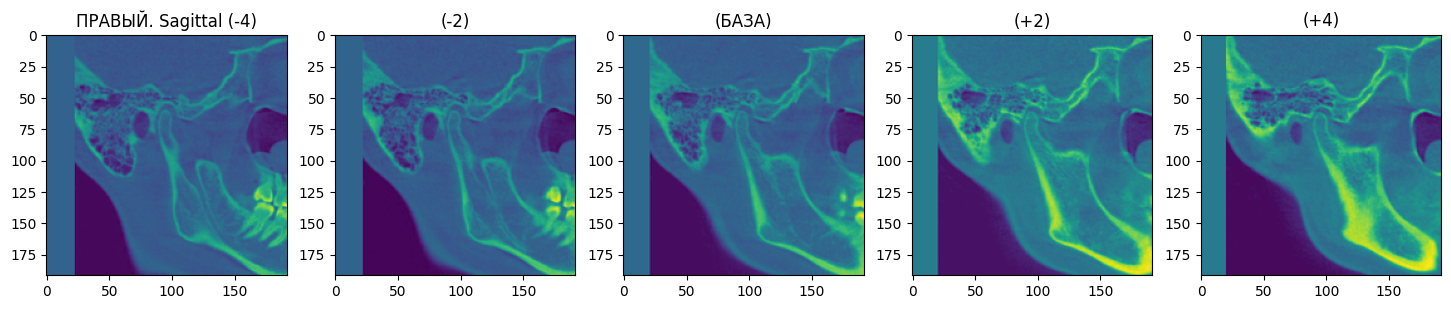

In [19]:
# ПРАВЫЙ. Базовые проекции
img_shape = r_rotated_volume2.shape
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].set_title("ПРАВЫЙ. Axial")
axes[0].imshow(r_rotated_volume2[r_shift0,:,:])
axes[0].axhline(center, color='red', linewidth=0.5)
axes[0].axvline(center, color='red', linewidth=0.5)
axes[1].set_title("ПРАВЫЙ. Coronal")
flipped_coronal = np.flip(r_rotated_volume2[:, img_shape[1]//2, :], axis=0)
axes[1].imshow(flipped_coronal)
axes[1].axhline(center, color='red', linewidth=0.5)
axes[1].axvline(center, color='red', linewidth=0.5)
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(18, 6))
axes[0].set_title("ПРАВЫЙ. Sagittal (-4)")
flipped_sagittal = np.flip(r_rotated_volume2[:,:, img_shape[2]//2-4])
axes[0].imshow(flipped_sagittal)
axes[1].set_title("(-2)")
flipped_sagittal = np.flip(r_rotated_volume2[:,:, img_shape[2]//2-2])
axes[1].imshow(flipped_sagittal)
axes[2].set_title("(БАЗА)")
flipped_sagittal = np.flip(r_rotated_volume2[:,:, img_shape[2]//2])
axes[2].imshow(flipped_sagittal)
axes[3].set_title("(+2)")
flipped_sagittal = np.flip(r_rotated_volume2[:,:, img_shape[2]//2+2])
axes[3].imshow(flipped_sagittal)
axes[4].set_title("(+4)")
flipped_sagittal = np.flip(r_rotated_volume2[:,:, img_shape[2]//2+4])
axes[4].imshow(flipped_sagittal)
plt.show()

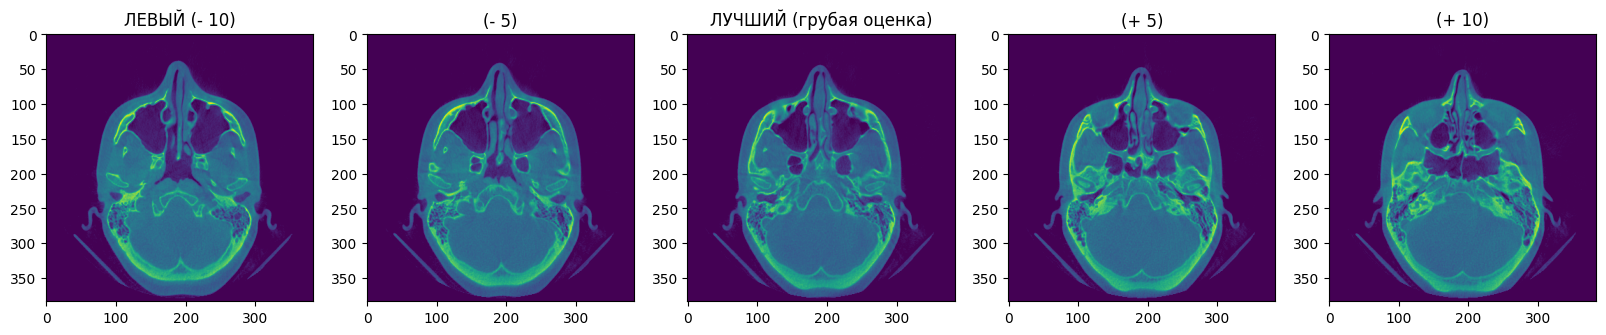

In [21]:
# ! ЛЕВЫЙ МЫЩЕЛОК !
# ГРУБАЯ оценка. Смотрим срезы в глубине. Корректируем shift0_l пока не найдём ЛУЧШИЙ МЫЩЕЛОК.
# НАДО КОРРЕКТИРОВАТЬ:
shift0_l = 164 + 8
#
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 8))
axes[0].set_title("ЛЕВЫЙ (- 10)")
axes[0].imshow(np_images[shift0_l-10,:,:])
axes[1].set_title("(- 5)")
axes[1].imshow(np_images[shift0_l-5,:,:])
axes[2].set_title("ЛУЧШИЙ (грубая оценка)")
axes[2].imshow(np_images[shift0_l,:,:])
axes[3].set_title("(+ 5)")
axes[3].imshow(np_images[shift0_l+5,:,:])
axes[4].set_title("(+ 10)")
axes[4].imshow(np_images[shift0_l+10,:,:])
plt.show()

In [22]:
# ЛЕВЫЙ. Вырезаем кубик вокруг левого мыщелка
l_box_side = round(np_images.shape[2]/2)
l_box_top = round((np_images.shape[0] - l_box_side)/2)
l_box_bottom = l_box_top + l_box_side
l_box_left =  0
l_box_right = l_box_side
l_box_forward = round(np_images.shape[2]/4)
l_box_back = l_box_forward + l_box_side
l_box = np_images[l_box_top:l_box_bottom , l_box_forward:l_box_back , l_box_left:l_box_right]

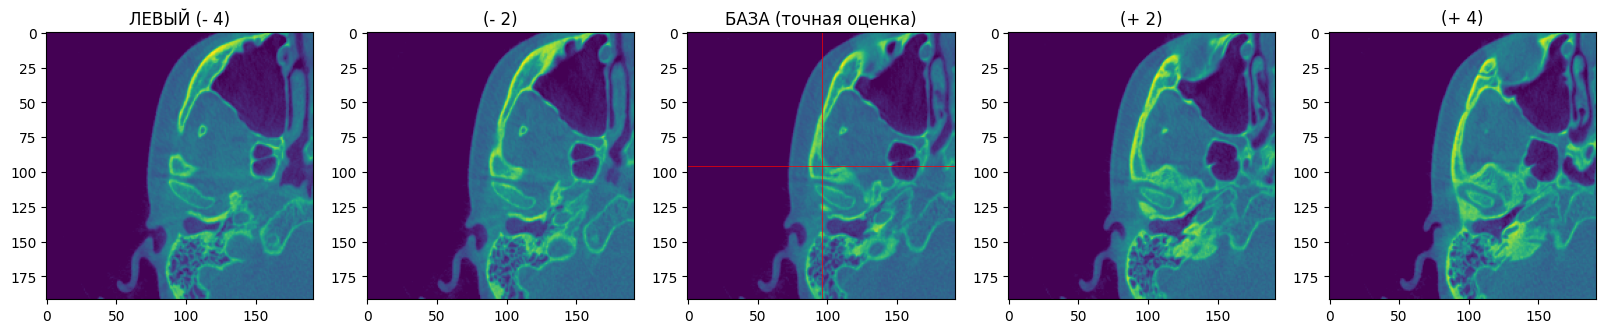

In [39]:
# ЛЕВЫЙ. ТОЧНАЯ оценка. Дальше смотрим срезы в глубине. Корректируем l_shift0 пока не найдём САМЫЙ ЛУЧШИЙ МЫЩЕЛОК. Это будет БАЗА
# НАДО КОРРЕКТИРОВАТЬ:
l_shift0 = shift0_l - 48
#
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 8))
axes[0].set_title("ЛЕВЫЙ (- 4)")
axes[0].imshow(l_box[l_shift0-4,:,:])
axes[1].set_title("(- 2)")
axes[1].imshow(l_box[l_shift0-2,:,:])
axes[2].set_title("БАЗА (точная оценка)")
axes[2].axhline(l_box.shape[0] / 2, color='red', linewidth=0.5)
axes[2].axvline(l_box.shape[0] / 2, color='red', linewidth=0.5)
axes[2].imshow(l_box[l_shift0,:,:])
axes[3].set_title("(+ 2)")
axes[3].imshow(l_box[l_shift0+2,:,:])
axes[4].set_title("(+ 4)")
axes[4].imshow(l_box[l_shift0+4,:,:])
plt.show()

In [25]:
# ЛЕВЫЙ. Сдвиг в ГЛУБИНУ на уровень БАЗА
translation_matrix0_l = np.array([[1, 0, 0, l_shift0],
                               [0, 1, 0, 0],
                               [0, 0, 1, 0],
                               [0, 0, 0, 1]])
l_shifted_volume0 = affine_transform(l_box, translation_matrix0_l, order=0, mode='constant')

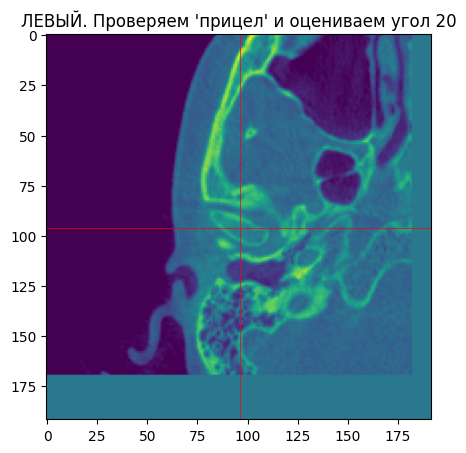

In [33]:
# ЛЕВЫЙ. Корректируем l_shift1 и l_shift2 пока не установим 'ПРИЦЕЛ' в центр мыщелка) 
# НАДО КОРРЕКТИРОВАТЬ:
l_shift1 = 34 - 12 # сдвиг вверх
l_shift2 = 10  # сдвиг влево
l_angle = 20 # угол поворота
#
translation_matrix1_l = np.array([[1, 0, 0, 0],
                               [0, 1, 0, l_shift1],
                               [0, 0, 1, 0],
                               [0, 0, 0, 1]])
# сдвиг влево
translation_matrix2_l = np.array([[1, 0, 0, 0],
                               [0, 1, 0, 0],
                               [0, 0, 1, l_shift2],
                               [0, 0, 0, 1]])
l_shifted_volume01 = affine_transform(l_shifted_volume0, translation_matrix1_l, order=0, mode='constant')
l_shifted_volume02 = affine_transform(l_shifted_volume01, translation_matrix2_l, order=0, mode='constant')
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
axes.set_title("ЛЕВЫЙ. Проверяем 'прицел' и оцениваем угол " + str(l_angle))
axes.imshow(l_shifted_volume02[0])
axes.axhline(l_shifted_volume02[0].shape[0] / 2, color='red', linewidth=0.5)
axes.axvline(l_shifted_volume02[0].shape[1] / 2, color='red', linewidth=0.5)
plt.show()

In [34]:
# ЛЕВЫЙ. Трансформируем КУБИК и поворачиваем вокруг оси 0 (торчком)
l_shifted_volume1 = affine_transform(l_box, translation_matrix1_l, order=0, mode='constant')
l_shifted_volume2 = affine_transform(l_shifted_volume1, translation_matrix2_l, order=0, mode='constant')
l_rotated_volume2 = rotate(l_shifted_volume2, l_angle, axes=(1, 2), reshape=False, mode='nearest')
center = l_rotated_volume2[0::].shape[0] / 2

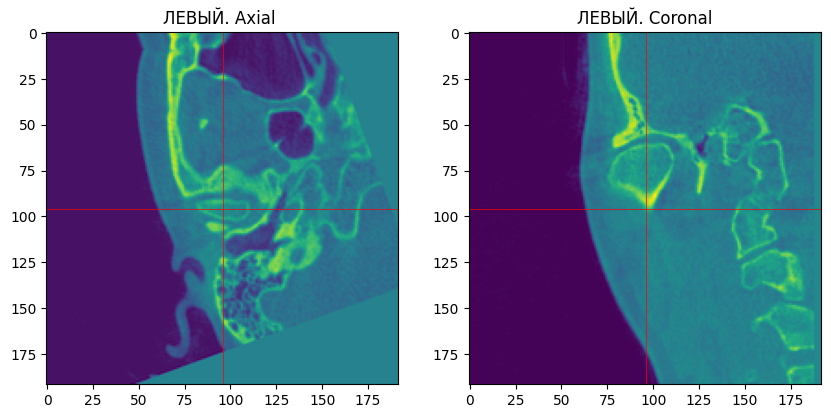

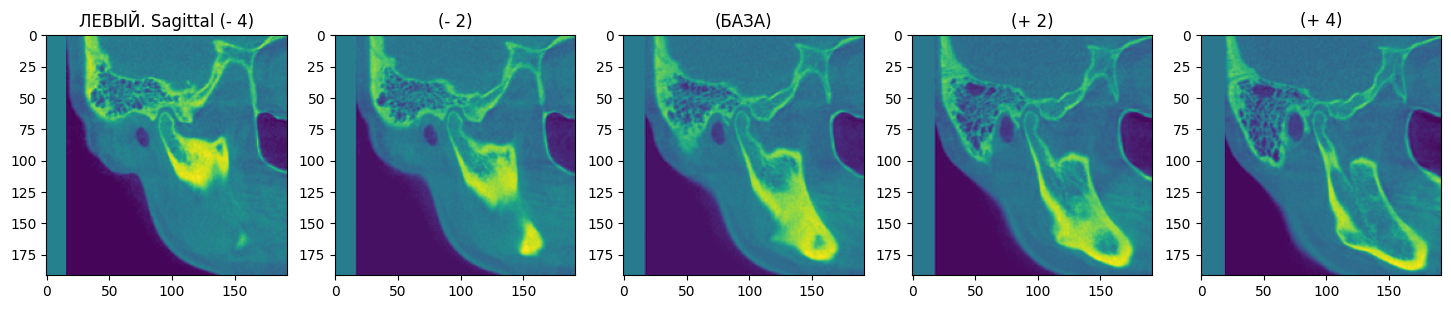

In [35]:
# ЛЕВЫЙ. Базовые проекции
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].set_title("ЛЕВЫЙ. Axial ")
axes[0].imshow(l_rotated_volume2[r_shift0,:,:])
axes[0].axhline(center, color='red', linewidth=0.5)
axes[0].axvline(center, color='red', linewidth=0.5)
axes[1].set_title("ЛЕВЫЙ. Coronal")
flipped_coronal = np.flip(l_rotated_volume2[:, img_shape[1]//2, :], axis=0)
axes[1].imshow(flipped_coronal)
axes[1].axhline(center, color='red', linewidth=0.5)
axes[1].axvline(center, color='red', linewidth=0.5)
plt.show()

# САГИТТАЛЬНЫЙ
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(18, 6))
axes[0].set_title("ЛЕВЫЙ. Sagittal (- 4)")
flipped_sagittal = np.flip(l_rotated_volume2[:,:, img_shape[2]//2-4])
axes[0].imshow(flipped_sagittal)
axes[1].set_title("(- 2)")
flipped_sagittal = np.flip(l_rotated_volume2[:,:, img_shape[2]//2-2])
axes[1].imshow(flipped_sagittal)
axes[2].set_title("(БАЗА)")
flipped_sagittal = np.flip(l_rotated_volume2[:,:, img_shape[2]//2])
axes[2].imshow(flipped_sagittal)
axes[3].set_title("(+ 2)")
flipped_sagittal = np.flip(l_rotated_volume2[:,:, img_shape[2]//2+2])
axes[3].imshow(flipped_sagittal)
axes[4].set_title("(+ 4)")
flipped_sagittal = np.flip(l_rotated_volume2[:,:, img_shape[2]//2+4])
axes[4].imshow(flipped_sagittal)

plt.show()